In [1]:
import tensorflow as tf
import urllib
import tarfile
import os

import numpy as np
import pets

import matplotlib.pyplot as plt
%matplotlib inline

data_dir ="data/"
if not os.path.isdir(data_dir):
    os.mkdir(data_dir)
print("Using GPU ", tf.test.is_gpu_available())    

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
Using GPU  False


In [2]:
pets.download_and_extract('data','.')

In [3]:
class_to_index = {'cat':0 , 'dog':1}
index_to_class = {0:'cat' ,1: 'dog'}

train_annot , count_train = pets.cats_vs_dogs_annotations('data/annotations/trainval.txt')
test_annot , count_test = pets.cats_vs_dogs_annotations('data/annotations/test.txt')

print("Training Examples :" , count_train)
print("Test Examples :" , count_test)


Training Examples : 3680
Test Examples : 3669


In [24]:
image_dir ='data/images/'

def get_random_batch(annot , batch_size = 4):
    all_keys = list(annot.keys())
#     print("ALL KEYS :" ,all_keys)
    total_examples = len(all_keys)
    indices = np.random.choice(range(total_examples) , batch_size)#This selects random  and different number from the length of the training set and returns a list of random numbers (here 8) 
    
#     print("indices :" , indices)
    x = np.zeros((batch_size , 128 ,128 , 3))# As we are using the pretrained weigths of mobileNet_v2 , we use this given size
    y = np.zeros((batch_size , 1))# since we have binary output we have only 1-D output
    images  =  []
    for i  , index in enumerate(indices):
        image_path = os.path.join(image_dir , all_keys[index])
        image = tf.keras.preprocessing.image.load_img(
        image_path , target_size=(128,128)
        )
#         print("Image :" , image)
        arr = tf.keras.preprocessing.image.img_to_array(image)#Coverting the image to numpy array of range 0 - 255
#         print("The val of arr after converting to numpy array", arr)
        arr = tf.keras.applications.mobilenet_v2.preprocess_input(arr) # Normalized values
#         print("The val of arr after mobilenet_v2 preprocessing", arr)
        arr = np.expand_dims(arr , axis =0)
#         print("Exapnd dims:", arr)
        x[i] = arr
        y[i] = class_to_index[annot[all_keys[index]]]# Return a number "0 for cat" and " 1 for dog"
        images.append(image)
    return x, y ,images


Displaying first 8 examples..


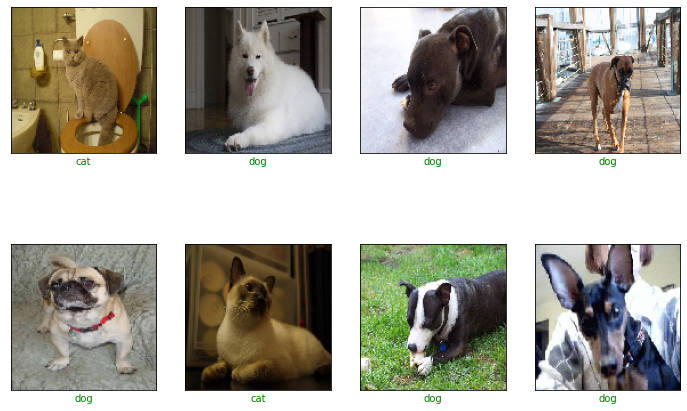

In [25]:
x , y , images = get_random_batch(train_annot , batch_size=8)
pets.display_examples(x,y,y, images , index_to_class).show()

In [27]:
mnet = tf.keras.applications.mobilenet_v2.MobileNetV2(
    include_top=False , 
    pooling= 'avg',
    weights='imagenet',
    input_shape=(128 ,128 ,3)    
)
mnet.summary()

Model: "mobilenetv2_1.00_128"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 129, 129, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 64, 64, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 64, 64, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________

In [28]:
def create_model():
    model = tf.keras.models.Sequential([
        mnet , 
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(1 ,activation = 'sigmoid')
    ])
    model.layers[0].trainable = False # In transfer learning we dont need to train the pretrained weights
    model.compile(loss ="binary_crossentropy" , optimizer= "Adam" , metrics= ['accuracy'])
    return model
model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_128 (Functi (None, 1280)              2257984   
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


In [37]:
def data_generator( batch_size, annot ):
    while True:
        x , y , _ = get_random_batch(annot , batch_size)
        yield(x, y)
        

In [38]:
batch_size = 32
steps_per_epoch = int(count_train/batch_size)
validation_steps = int(count_test/batch_size)

print("Training steps : " ,steps_per_epoch)
print("validation steps : " ,validation_steps )

Training steps :  115
validation steps :  114


In [39]:
%%time
_ = model.fit_generator(
    data_generator(batch_size , train_annot ),
    validation_data= data_generator(batch_size, test_annot),
    steps_per_epoch=steps_per_epoch ,
    validation_steps=validation_steps,
    epochs=1
) 

115/115 [==============================] - 91s 792ms/step - loss: 0.1071 - accuracy: 0.9666 - val_loss: 0.0781 - val_accuracy: 0.9783
Wall time: 1min 31s


In [42]:
x , y , images = get_random_batch(test_annot , batch_size =8)
preds = model.predict(x)


Displaying first 8 examples..


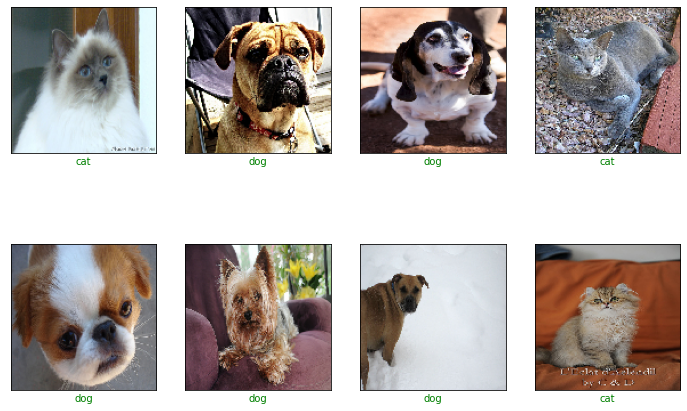

In [43]:
pets.display_examples(x , y , preds , images ,  index_to_class).show()